In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q -o '/content/drive/MyDrive/PACS/PACS.zip'

**Import Libraries**

In [3]:
import os
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.models as models
from torchvision import transforms

from matplotlib import image
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from collections import Counter

**Set Constants and Hyperparameters**

In [4]:
DEVICE = 'cuda' #'cpu'
print("Using device: ", torch.cuda.get_device_name(0))

NUM_CLASSES = 7
CLASSES = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']

USE_PRETRAINED = True
FEATURE_EXTRACT = True

VALIDATION_SPLIT = 0.1

MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
GAMMA = 0.2
STEP_SIZE = 20 # Step size for the learning rate scheduler     

LR = 1e-4
BATCH_SIZE = 128
NUM_EPOCHS = 50 

LOG_FREQUENCY = 5 #step-frequency for reporting of logs 

DIR_PHOTO = '/content/kfold/photo'
DIR_ART = '/content/kfold/art_painting'
DIR_CARTOON = '/content/kfold/cartoon'
DIR_SKETCH = '/content/kfold/sketch'

SOURCE_DIR = DIR_PHOTO # Source Domain
TARGET_DIR = DIR_SKETCH # Target Domain

#Loss Hyperparams
LAMBDA1 = 0.5
LAMBDA2 = 0.2
LAMBDA3 = 0.3

Using device:  Tesla K80


**Take a look at the source data**

Class: elephant img_file: /content/kfold/photo/elephant/064_0097.jpg


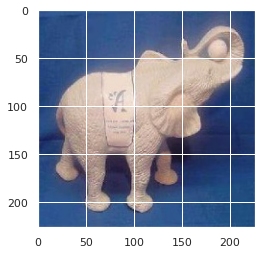

In [5]:
# Read a random image from source domain

class_idx = random.randint(0, NUM_CLASSES-1) # Random class
class_name = CLASSES[class_idx]

class_dir = os.path.join(SOURCE_DIR, class_name)
img_idx = random.randint(0, len(os.listdir(class_dir))) # Random Image 

img_path = os.path.join(class_dir, os.listdir(class_dir)[img_idx])

img = image.imread(img_path)
plt.imshow(img)
print(f"Class: {class_name} img_file: {img_path}")

**Take a look at the target data**

Class: elephant img_file: /content/kfold/sketch/elephant/n02503517_2547-5.png


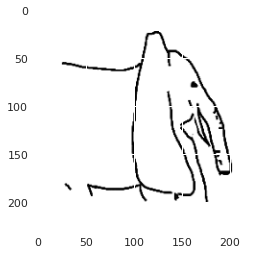

In [6]:
# Read a random image from target domain

class_idx = random.randint(0, NUM_CLASSES-1) # Random class
class_name = CLASSES[class_idx]

class_dir = os.path.join(TARGET_DIR, class_name)
img_idx = random.randint(0, len(os.listdir(class_dir))) # Random Image 

img_path = os.path.join(class_dir, os.listdir(class_dir)[img_idx])

img = image.imread(img_path)
plt.imshow(img)
print(f"Class: {class_name} img_file: {img_path}")

**Initialise Model**

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

model = models.resnet18(pretrained=USE_PRETRAINED) # feature extractor
set_parameter_requires_grad(model, FEATURE_EXTRACT)

num_ftrs = model.fc.in_features
model.fc =  nn.Linear(num_ftrs, NUM_CLASSES) # classifier

model = model.to(DEVICE)

INPUT_SIZE = 224

**Data Preprocessing**

In [8]:
mean = [0.485, 0.456, 0.406] # ImageNet means
std = [0.229, 0.224, 0.225] # ImageNet standard deviations

data_transforms = transforms.Compose([transforms.CenterCrop(INPUT_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])

**Prepare Dataset**

In [9]:
source_dataset = torchvision.datasets.ImageFolder(SOURCE_DIR, transform=data_transforms) 
target_dataset = torchvision.datasets.ImageFolder(TARGET_DIR, transform=data_transforms)

print(f"Source: {len(source_dataset)} images")
print(f"Target: {len(target_dataset)} images")

#Splitting source dataset into train and validation

val_len = int(VALIDATION_SPLIT * len(source_dataset))
train_len = len(source_dataset) - val_len

print(f"Source Train: {train_len} images")
print(f"Source Val: {val_len} images")

train_set, val_set = torch.utils.data.random_split(source_dataset, [train_len, val_len])

Source: 1670 images
Target: 3929 images
Source Train: 1503 images
Source Val: 167 images


**Prepare Dataloaders**

In [10]:
# Setting up dataloaders
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

**Class to Index Mapping and Distribution of Train and Validation sets**

In [11]:
print(f"Class to index mapping: {source_dataset.class_to_idx}")

print("Distribution of classes: ")
train_classes = [label for _, label in train_set]
print(f"Train: {Counter(train_classes)}")

val_classes = [label for _, label in val_set]
print(f"Val: {Counter(val_classes)}")

Class to index mapping: {'dog': 0, 'elephant': 1, 'giraffe': 2, 'guitar': 3, 'horse': 4, 'house': 5, 'person': 6}
Distribution of classes: 
Train: Counter({6: 391, 5: 252, 1: 187, 4: 174, 0: 170, 3: 167, 2: 162})
Val: Counter({6: 41, 5: 28, 4: 25, 2: 20, 0: 19, 3: 19, 1: 15})


**Define Loss Functions**

In [12]:
#Defining the loss function

class WeightedCrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(WeightedCrossEntropyLoss, self).__init__()

  def forward(self, input, threshold=0.95):
    softmax_input = F.softmax(input, dim=1)
    max_sigma, y_pred = torch.max(softmax_input, dim=1) # Get highest probability and corresponding class
    
    loss = max_sigma * F.cross_entropy(input, y_pred)
    mask = max_sigma >= threshold # Loss is 0 if this condition is not met (max_sigma >= 0.95)
    loss = loss * mask
    loss = loss.mean()

    return loss

class EntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(EntropyLoss, self).__init__()

  def forward(self, input):
    b = F.softmax(input, dim=1) * F.log_softmax(input, dim=1)
    b = -1.0 * b.mean()
    return b

class CustomLoss(nn.Module):
  def __init__(self, weight=None, size_average=True):
    super(CustomLoss, self).__init__()
    self.ce = nn.CrossEntropyLoss()
    self.wce = WeightedCrossEntropyLoss()
    self.e = EntropyLoss()

    # Hyperparameters for weighted sum of losses
    self.lambda1 = torch.tensor([LAMBDA1], device=DEVICE)
    self.lambda2 = torch.tensor([LAMBDA2], device=DEVICE)
    self.lambda3 = torch.tensor([LAMBDA3], device=DEVICE)

  def forward(self, inputs1, targets1, inputs2):
    """
    inputs1, targets1 are the network output and labels from source domain
    inputs2 is the network output from target domain
    """
    ce_loss = self.ce(inputs1, targets1)
    wce_loss = self.wce(inputs2)
    e_loss = self.e(inputs2)

    loss = self.lambda1*ce_loss + self.lambda2*wce_loss + self.lambda3*e_loss
    return loss, ce_loss, wce_loss, e_loss 

**Creating an instance of the loss function, optimizer and scheduler**

In [13]:
# Create an instance of the loss function
criterion = CustomLoss()

#Define the optimizer and scheduler
parameters_to_optimize = model.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Training the model**

In [14]:
n_total_steps = len(train_dataloader)

accuracy_val = list()

loss_list = list()
ce_loss_list = list()
wce_loss_list = list()
e_loss_list = list()

for epoch in range(NUM_EPOCHS):
  model.train(True)
  
  # Using the unlabeled target data during training
  test_iterator = iter(test_dataloader)
  
  loss_total = 0
  ce_loss_total = 0
  wce_loss_total = 0
  e_loss_total = 0
  
  # Iterate over source dataset
  for step, (images1, labels1) in enumerate(train_dataloader):
    # Getting data from the target dataset
    try:
      images2, _ = next(test_iterator)
    except StopIteration:
      test_iterator = iter(test_dataloader)
      images2, _ = next(test_iterator)

    images1 = images1.to(DEVICE)
    labels1 = labels1.to(DEVICE)
    images2 = images2.to(DEVICE)
    
    outputs1 = model(images1)
    outputs2 = model(images2)

    loss, ce_loss, wce_loss, e_loss = criterion(outputs1, labels1, outputs2)
    
    optimizer.zero_grad() #Zeroing gradients
    loss.backward()
    optimizer.step()

    loss_total += loss.item()
    ce_loss_total += ce_loss.item()
    wce_loss_total += wce_loss.item()
    e_loss_total += e_loss.item()

    if (step+1) % LOG_FREQUENCY == 0:
      print(f"Step {step+1}/{n_total_steps} Loss={loss.item():.4f} CrossEntropyLoss: {ce_loss.item():.4f} WeightedCrossEntropyLoss: {wce_loss.item():.4f} EntropyLoss: {e_loss.item():.4f}")

  # Get Validation Accuracy
  model.train(False)
  n_correct = 0
  n_samples = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = model(images)

    _, preds = torch.max(outputs, 1) # Get Predictions
    
    n_correct = (preds == labels).sum().item()
    n_samples += labels.shape[0] 
  
  val_acc = n_correct / n_samples
  
  # Update Scheduler
  scheduler.step()

  # Store Losses
  loss_list.append(loss_total/n_total_steps)
  ce_loss_list.append(ce_loss_total/n_total_steps)
  wce_loss_list.append(wce_loss_total/n_total_steps)
  e_loss_list.append(e_loss_total/n_total_steps)
  accuracy_val.append(val_acc)

  print(f"Epoch {epoch+1}/{NUM_EPOCHS} LearningRate={scheduler.get_last_lr()}  ValAccuracy={val_acc:.4f}\n")

Step 5/11 Loss=1.0450 CrossEntropyLoss: 1.9346 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2590
Step 10/11 Loss=0.9914 CrossEntropyLoss: 1.8266 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2604
Epoch 1/50 LearningRate=[0.0001]  ValAccuracy=0.2656

Step 5/11 Loss=0.9774 CrossEntropyLoss: 1.7979 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2617
Step 10/11 Loss=0.9875 CrossEntropyLoss: 1.8173 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2628
Epoch 2/50 LearningRate=[0.0001]  ValAccuracy=0.3203

Step 5/11 Loss=0.9152 CrossEntropyLoss: 1.6722 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2635
Step 10/11 Loss=0.9254 CrossEntropyLoss: 1.6923 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2640
Epoch 3/50 LearningRate=[0.0001]  ValAccuracy=0.4531

Step 5/11 Loss=0.9068 CrossEntropyLoss: 1.6549 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2645
Step 10/11 Loss=0.8798 CrossEntropyLoss: 1.6006 WeightedCrossEntropyLoss: 0.0000 EntropyLoss: 0.2650
Epoch 4/50 LearningRate=[0.0001]  

**Analysing the loss and validation performance**

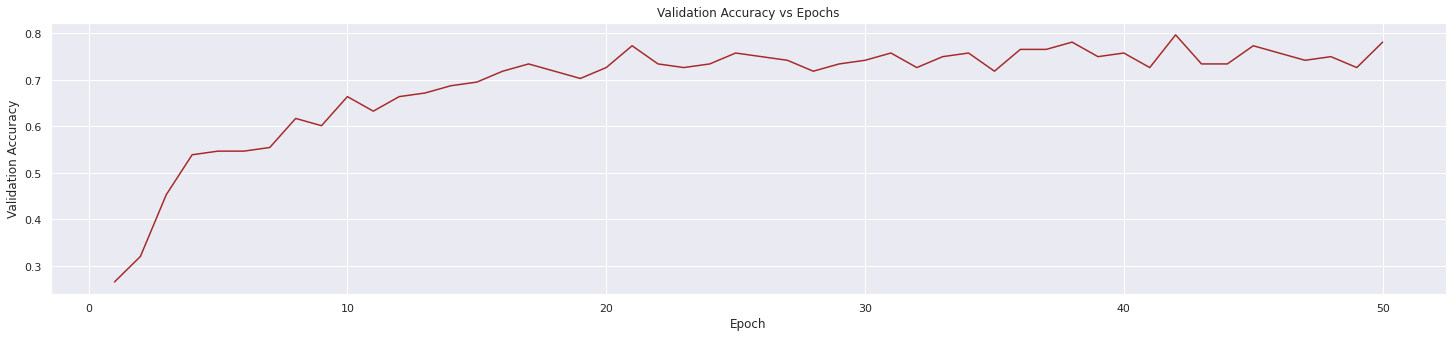

In [15]:
# Plotting Validation Accuracy
x = list(range(1, NUM_EPOCHS+1))

plt.figure(figsize=(25, 5))
plt.plot(x, accuracy_val, label='', color='brown')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.show()

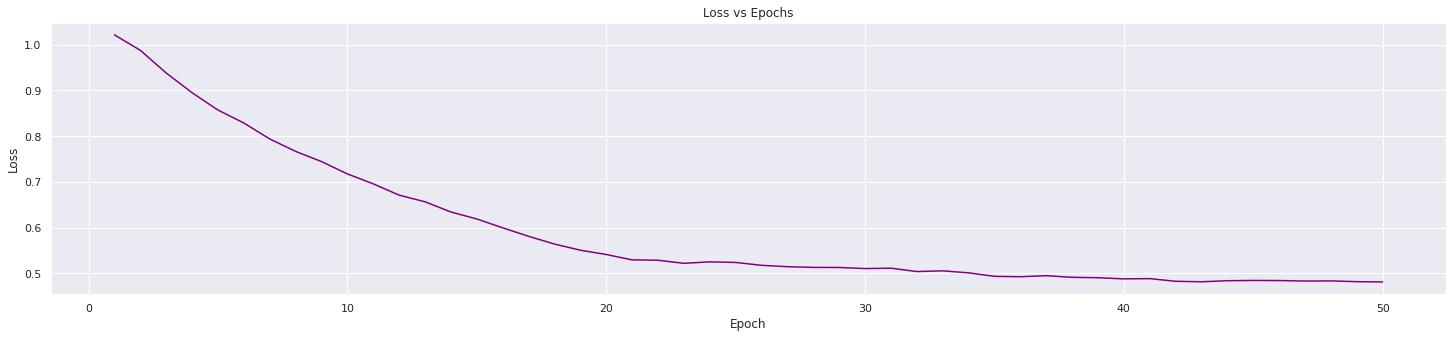

In [16]:
# Plotting Loss
x = list(range(1, NUM_EPOCHS+1))

plt.figure(figsize=(25, 5))
plt.plot(x, loss_list, label='total loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()

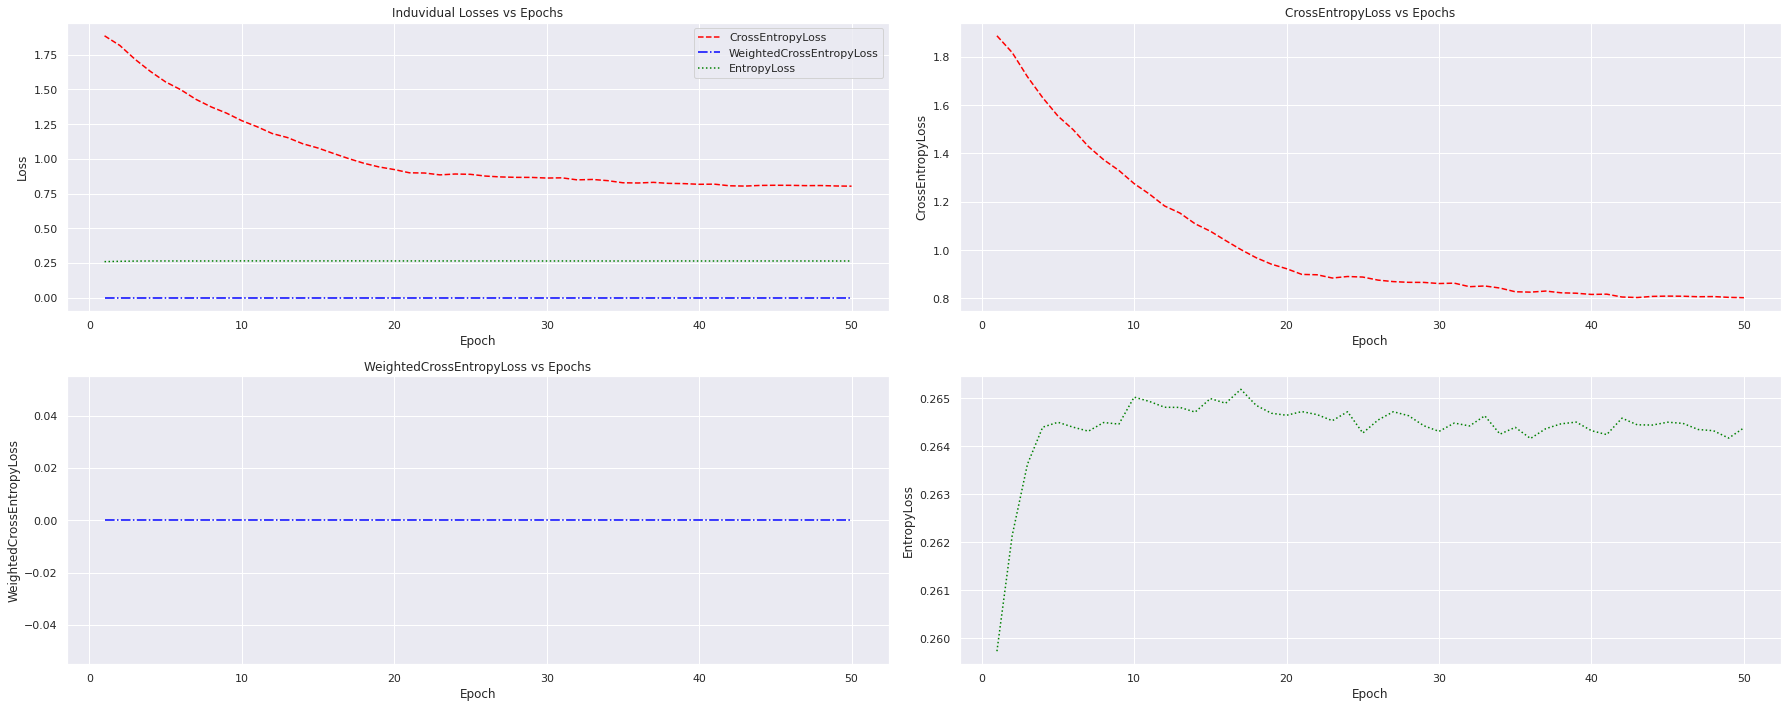

In [17]:
# Plotting induvidual loss components
x = list(range(1, NUM_EPOCHS+1))

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(25, 10))

axes[0][0].plot(x, ce_loss_list, label='CrossEntropyLoss', linestyle='--', color='red')
axes[0][0].plot(x, wce_loss_list, label='WeightedCrossEntropyLoss', linestyle='-.', color='blue')
axes[0][0].plot(x, e_loss_list, label='EntropyLoss', linestyle=':', color='green')
axes[0][0].set_xlabel('Epoch')
axes[0][0].set_ylabel('Loss')
axes[0][0].set_title('Induvidual Losses vs Epochs')
axes[0][0].legend()

axes[0][1].plot(x, ce_loss_list, label='CrossEntropyLoss', linestyle='--', color='red')
axes[0][1].set_xlabel('Epoch')
axes[0][1].set_ylabel('CrossEntropyLoss')
axes[0][1].set_title('CrossEntropyLoss vs Epochs')

axes[1][0].plot(x, wce_loss_list, label='WeightedCrossEntropyLoss', linestyle='-.', color='blue')
axes[1][0].set_xlabel('Epoch')
axes[1][0].set_ylabel('WeightedCrossEntropyLoss')
axes[1][0].set_title('WeightedCrossEntropyLoss vs Epochs')

axes[1][1].plot(x, e_loss_list, label='EntropyLoss', linestyle=':', color='green')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel('EntropyLoss')
axes[1][0].set_title('WeightedCrossEntropyLoss vs Epochs')

figure.tight_layout()

**Testing the model**

In [18]:
#Evaluating Accuracy on Test set
y_pred =torch.zeros(0,dtype=torch.long, device='cpu')
y_test =torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = model(images)
    
    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct = (predictions == labels).sum().item()

    # Append batch prediction results
    y_pred = torch.cat([y_pred, predictions.view(-1).cpu()])
    y_test = torch.cat([y_test, labels.view(-1).cpu()])
  
  acc = 100 * n_correct / n_samples
  print(f"Test Accuracy: {acc:.4f}%")

Test Accuracy: 0.3309%


**Confusion Matrix**

Confusion Matrix
[[  0   1   8 181   1   0 581]
 [  0   1  10 254   0   0 475]
 [  0   1  52 149  33   0 518]
 [  0   0   1 277   1   0 329]
 [  0   1  25 189   6   0 595]
 [  0   0   0  21   3   0  56]
 [  0   0   0   9   0   0 151]]


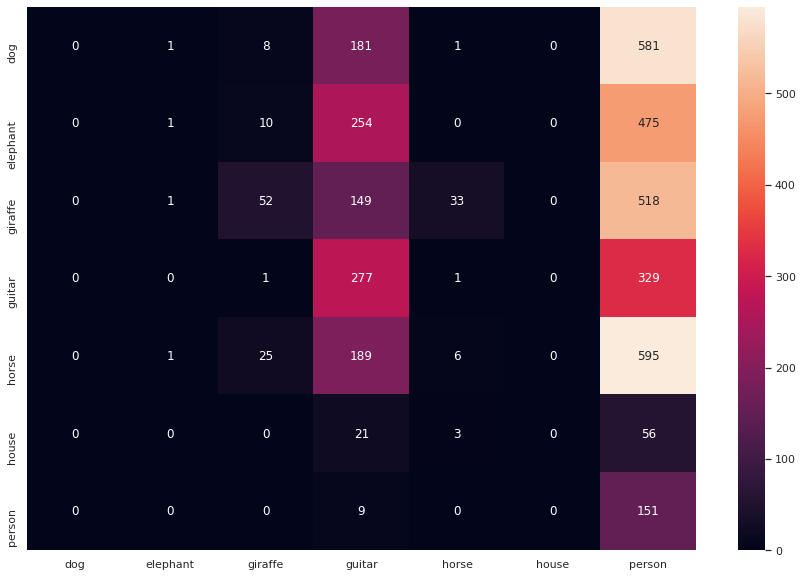

In [19]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test.numpy(), y_pred.numpy())
print("Confusion Matrix")
print(conf_mat)

columns={v:k for k,v in source_dataset.class_to_idx.items()}
index={v:k for k,v in target_dataset.class_to_idx.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test.numpy(), y_pred.numpy()), dtype='int64').rename(columns=columns, index=index)
plt.figure(figsize=(15,10))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

**Classification Report**

In [20]:
# Classification Report
idx_to_class = {v:k for k,v in target_dataset.class_to_idx.items()}

y_test_list = list(y_test.numpy())
y_pred_list = list(y_pred.numpy())

for i in range(len(y_test_list)):
  y_test_list[i] = idx_to_class[y_test_list[i]]

for i in range(len(y_pred_list)):
  y_pred_list[i] = idx_to_class[y_pred_list[i]]

print("Classification Report")
print(classification_report(y_test_list, y_pred_list))

Classification Report
              precision    recall  f1-score   support

         dog       0.00      0.00      0.00       772
    elephant       0.25      0.00      0.00       740
     giraffe       0.54      0.07      0.12       753
      guitar       0.26      0.46      0.33       608
       horse       0.14      0.01      0.01       816
       house       0.00      0.00      0.00        80
      person       0.06      0.94      0.11       160

    accuracy                           0.12      3929
   macro avg       0.18      0.21      0.08      3929
weighted avg       0.22      0.12      0.08      3929



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
